In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_venn as venn
import seaborn as sns
from glob import glob
from copy import copy, deepcopy
from scipy import stats
from difflib import SequenceMatcher
from matplotlib.colors import Normalize
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
import wordcloud

# Description
I'll be honest -- I'm not a huge fan of gene ontology analysis, and I have my doubts as to what insights can really be gained from it. But, I was told that it is required, so here goes. Most folks would do this in R, but I'm gonna stick to python and do things manually. There is much to this notebook that is *not* automated, so probably not something that will be very fun to reproduce. 

Here is the plan:
* Put our top genes significantly contributing to each PLS gradient into ToppGene to get signficantly enriched terms.
* Cluster those terms by textual similarily, and use that to assign all terms to major categories.
* Visualize term categories for each component

In [2]:
figdir = 'figures/'

# Get significant genes
First, we need to take the "significantly" contributing genes from each component. If we set an alpha as 0.05, we then divide that in half because we are looking at two tails, and then we divide again by 3 because we are looking at3 components. That means, we are taking the top and bottom 0.8% of genes from each component (based on PLS weight), and considering those top contributing genes

In [3]:
# This was created in NB3: PLS_ModelExploration
comps = pandas.read_csv('tables/all_comps.csv',index_col=0)
comps.head()

,gene_symbol,gene_name,C1,C2,C3,C1_genelist,C2_genelist,C3_genelist
0,A1BG,alpha-1-B glycoprotein,0.002973,0.004339,-0.021710,0.0,0.0,1.0
1,A1BG-AS1,NaN,-0.005849,-0.005274,-0.001815,0.0,0.0,0.0
2,A2M,alpha-2-macroglobulin,0.006580,0.008360,0.002613,0.0,0.0,0.0
3,A2ML1,alpha-2-macroglobulin-like 1,-0.002902,-0.003456,-0.006931,0.0,0.0,0.0
4,A3GALT2,NaN,-0.000181,0.002546,0.004099,0.0,0.0,0.0


In [4]:
# Threshold for significant contribution
perc = 0.025 / 3 
thresh = int(round(comps.shape[0] * perc))

# put all top genes into a df, and indicate whether they are coming from the head or tail of the PLS component
topgenes = pandas.DataFrame()
for c in ['C1','C2','C3']:
    genes = comps.sort_values(c).dropna().gene_symbol.iloc[-thresh:].tolist()
    genes += comps.sort_values(c).dropna().gene_symbol.iloc[:thresh].tolist()
    topgenes[c] = genes
topgenes.loc[:,'tail'] = (['negative'] * thresh) + (['positive'] * thresh)

In [5]:
topgenes[topgenes['tail']=='positive']

,C1,C2,C3,tail
130,CTXN3,TDRD1,MGP,positive
131,PRRX1,MET,PNMT,positive
132,ABHD12B,MGP,KCTD4,positive
133,TNNT2,CPLX2,PTGER3,positive
134,ASGR2,COL5A1,CPNE6,positive
...,...,...,...,...
255,COL11A1,LCN15,MAD2L2,positive
256,KCNK2,NPTX2,NID2,positive
257,GUCY1A2,GLRX,SNAPC5,positive
258,NKX1-2,FASTKD1,EPB41L4B,positive


Lets pause for a moment and just look at genes that are significantly expressed in more than one component

In [6]:
# genes expressed significantly in all 3 components
olapc123 = set(topgenes.C3.values) & set(topgenes.C1.values) & set(topgenes.C2.values)
olapc123

{'ARL9',
 'CTXN3',
 'DSP',
 'GAL',
 'HRH3',
 'MET',
 'MGAT4C',
 'MGP',
 'PRRX1',
 'RASIP1',
 'TEX26'}

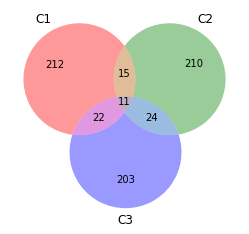

In [7]:
# Venn diagram of gene overlap across components
venn.venn3([set(topgenes.C1.values), 
            set(topgenes.C2.values), 
            set(topgenes.C3.values)], ('C1', 'C2', 'C3'))

plt.show()

In [8]:
# save this if in case we want to use it later
topgenes.to_csv('data/PLSGXP_topgenes_list.csv')

# Run Toppgene analysis

Now we want to import each of the six gene sets (3 components x two tails) into the ToppFun analysis in ToppGene: https://toppgene.cchmc.org/enrichment.jsp

For each gene set, we will input the background gene set, which is all the genes included in the Allen Brain Atlas dataset. We will also be using Entrez ID. To get the Entrez ID of the whole Allen Dataset and the current gene sets, uncomment and run the cells below.

In [11]:
# (default is ~/abagen-data/microarray)
allendir = '~/abagen-data/microarray'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
probes.shape

(58692, 7)

In [12]:
# # uncomment to get all the entrez ids for all Allen genes (the background dataset)
# for x in np.unique(probes.entrez_id.values.astype(int)): print(x)

In [13]:
# # change this according to what gene set you want. For example, for C1 tail you would enter
# # jnk = probes[probes.gene_symbol.isin(topgenes[topgenes['tail']=='negative'].C1.values)].entrez_id.astype(int).values
# jnk = probes[probes.gene_symbol.isin(topgenes[topgenes['tail']=='positive'].C3.values)].entrez_id.astype(int).values
# for x in np.unique(jnk): print(x)

Next, you enter the gene set and the background set into the relevant boxes in ToppFun, and make sure EntrezID is selected as the input.

After pressing submit, check *only* the following boxes such that only the following terms are selected for the search:
* Go: Molecular Function
* Go: Biological Process
* Go: Cellular Component
* Human Phenotype
* Pathway
* Disease

Then press start. Once the results are produced, select "Download All" to create a spreadsheet.

Note that ToppGene is continously updating their databases, which means results will vary over time. The current ToppGene query was conducted on December 7th, 2021. To ensure results can be reproduced exactly, output of the December 7th analysis is stored in the `/data` directory. If you wish to run with your own results, change the paths below accordingly

In [14]:
# Here is what the outputs look like
c1 = pandas.read_csv('data/C1_Head.txt',sep='\t')
c1.head()

,Category,ID,Name,Source,p-value,q-value Bonferroni,q-value FDR B&H,q-value FDR B&Y,Hit Count in Query List,Hit Count in Genome,Hit in Query List
0,GO: Molecular Function,GO:0022836,gated channel activity,,0.000031,0.01197,0.006841,0.04481,11,349,"GRID1,KCNIP3,CACNG3,KCNV1,KCNB1,KCNJ4,KCNK2,KC..."
1,GO: Molecular Function,GO:0015459,potassium channel regulator activity,,0.000035,0.01368,0.006841,0.04481,5,54,"KCNIP3,KCNV1,KCNK2,KCNS1,KCNMB4"
2,GO: Molecular Function,GO:0005267,potassium channel activity,,0.000082,0.03218,0.010730,0.07025,7,150,"KCNIP3,KCNV1,KCNB1,KCNJ4,KCNK2,KCNS1,KCNMB4"
3,GO: Molecular Function,GO:0030594,neurotransmitter receptor activity,,0.000211,0.08272,0.014810,0.09703,6,123,"HTR1E,GRID1,CHRM1,HRH1,GABRA1,GABRA4"
4,GO: Molecular Function,GO:0001228,"DNA-binding transcription activator activity, ...",,0.000228,0.08931,0.014810,0.09703,12,513,"ONECUT2,PRRX1,FEZF2,OVOL2,LHX2,OTX1,BCL11B,CSR..."


# Summarize ToppGene analysis

In [15]:
# load all sheets
sheets = sorted(glob('data/C*.txt'))

# set palettes
palettes = ['cividis','cividis_r','viridis','viridis_r','magma','magma_r']

#### Word cloud
This doesn't end up making it into the manuscript, but just for fun, here's a word cloud summarizing the terms

In [16]:
# first, get rid of words that are not informative, and punctuation 
puncs = ['.','*','(',')','?','[',']','/','-',':',';','+',"\"","'s",',']
badwords = ['human','expression','associated','gene','role','mouse',
            'novel','protein','association','cell','allele','effect',
            'required','pathway','polymorphism','patient',
           'via','factor','level','study','activation','regulation',
           'induce','response','interaction','analysis','regulate',
           'promote','type','contribute','activity','mediate',
           'control','reveal','mice','murine','variant','increase',
           'model','marker','class','modulate','inwith','new',
           'region','family','function','mutation','functional',
           'essential','tissue','molecular','characterization',
           'mechanism','mutant','two','distinct','cause',
           'influence','population','identification','primary',
           'loss','expressed''vivo','complex','vitro']


========== C1_Head ==========


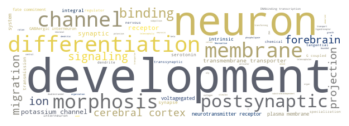

========== C1_Tail ==========


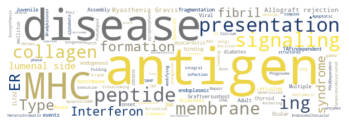

========== C2_Head ==========


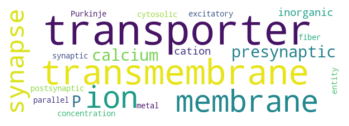

========== C2_Tail ==========


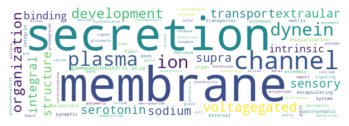

========== C3_Head ==========


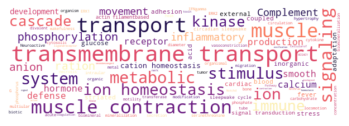

========== C3_Tail ==========


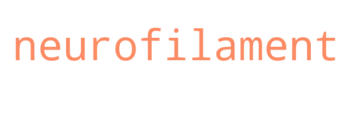

In [17]:
# Make word clouds!!

# categories to use
goodcats = ['GO: Biological Process',
           'GO: Cellular Component','Pathway',
           'GO: Molecular Function','Disease']

# some more words to get rid of 
addwords = ['positive','negative','component','involved',
            'pathway','process']

# for each sheet
for n,sheet in enumerate(sheets):
    # Open sheet and get name
    cdf = pandas.read_csv(sheet,sep='\t')
    flnm = os.path.split(sheet)[1].split('.')[0]
    print('='*10,flnm,'='*10)
    # Create one large string with all words in
    string = ''
    # for each category
    for cat in goodcats:
        # Get name term, remove punctuation and bad words and add to master string
        for i,row in cdf[cdf.Category==cat].iterrows():
            estr = row['Name']
            if pandas.isnull(estr): continue
            for punc in puncs:
                estr=estr.replace(punc,'')
            for word in badwords + addwords:
                estr=estr.replace(word,'')
            string += estr+' '
    # get rid of a few additional annoyances
    string = string.replace(' s ','').replace(' d ','').replace(' t ','')
    string = string.replace(' al ','').replace(' tic ',''
                                              ).replace(' ular ',' ')
    
    # make word cloud
    wc = wordcloud.WordCloud(max_words=100, background_color="white",
                             colormap=palettes[n],width=600,
                                # color_func=lambda *args, **kwargs: cmap
                                ).generate(string)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    # save if you wish
#     plt.savefig(os.path.join(figdir,'Enr_WC_%s'%flnm), bbox_inches = 'tight')
    plt.show() 

#### Categorized heat maps

In [18]:
# First, let's build all results into a single sheet
sheets = sorted(glob('data/C*.txt'))
catch = []
for n,sheet in enumerate(sheets):
    cdf = pandas.read_csv(sheet,sep='\t')
    flnm = os.path.split(sheet)[1].split('.')[0]
    cdf.loc[:,'component'] = flnm.split('_')[0]
    cdf.loc[:,'tail'] = flnm.split('_')[1]
    catch.append(cdf)

cdf = pandas.concat(catch)

In [19]:
# clean up the terms, but create a map so that there is a direct mapping
# between original terms and clean terms
to_remove = ['activity','negative','regulation','process',' of ','positive',
            ' to ','pathway',' from ','  '] # ' the ',' in '
terms = []
term_map = {}
for name in cdf.Name.values:
    if pandas.isnull(name): continue
    old_name = copy(name)
    for string in to_remove:
        name = name.replace(string,'')

    name = name.strip().lower()
    terms.append(name)
    term_map.update({name:old_name})

What comes next is a *super* janky way of making a terrible job just a tad easier. We are going to cluster all terms based on textual similarities. In doing so, most terms that are really similar to one another will end up in the same clusters. Then, we can manually add each term to a category, but we can do it in bunches instead of one by one.

In [20]:
# Create a correlation matrix of all terms based on textual similarity
length = len(terms)
cmat = np.zeros((length,length))
for i in range(length):
    for j in range(length):
        cmat[i,j] = SequenceMatcher(a=terms[i],b=terms[j]).ratio()

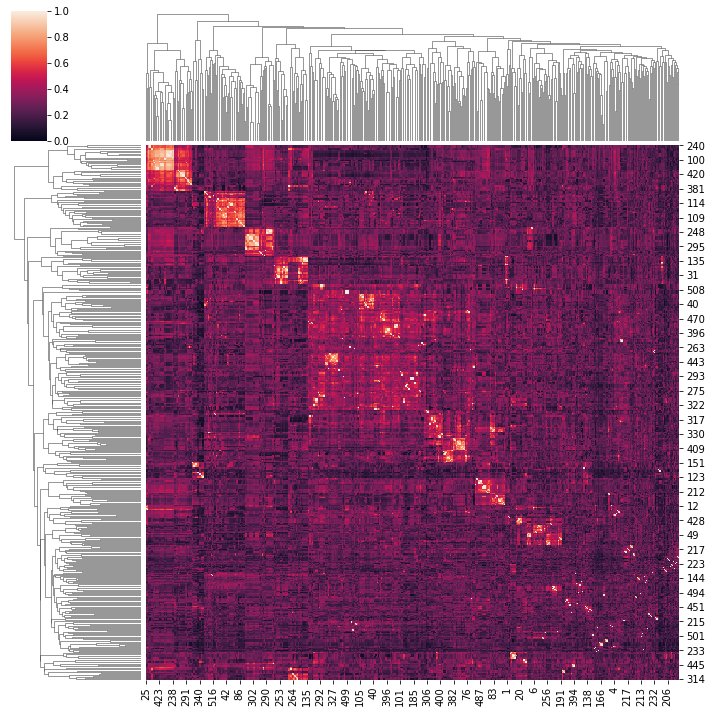

In [21]:
sns.clustermap(cmat)

In [22]:
# run clustering analysis across many difference instances of k, to find where clustering stability converges
# here, we're going to be looking for a very high resolution clustering
csol = pandas.DataFrame()
for i,k in enumerate(range(2,300)):
    if i%10==0: print('working on k =',k)
    d = cmat
    cluster = AgglomerativeClustering(n_clusters=k, affinity='euclidean', 
                                  linkage='ward')
    cluster.fit_predict(d)
    csol.loc[i,'k'] = k
    csol.loc[i,'sil_score'] = silhouette_score(d,cluster.labels_,random_state=123)
    csol.loc[i,'ch_score'] = calinski_harabasz_score(d,cluster.labels_)

working on k = 2
working on k = 12
working on k = 22
working on k = 32
working on k = 42
working on k = 52
working on k = 62
working on k = 72
working on k = 82
working on k = 92
working on k = 102
working on k = 112
working on k = 122
working on k = 132
working on k = 142
working on k = 152
working on k = 162
working on k = 172
working on k = 182
working on k = 192
working on k = 202
working on k = 212
working on k = 222
working on k = 232
working on k = 242
working on k = 252
working on k = 262
working on k = 272
working on k = 282
working on k = 292


For my run, it looks like there is an initial peak in silhouette score early on, but that is far too low resolution to be helpful. Anecdotally, there appears to be an "elbow" at k=190. We'll use that as the solution

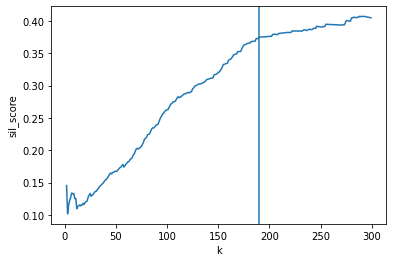

In [23]:
sns.lineplot(x='k',y='sil_score',data=csol)
#plt.xlim(150,250)
plt.axvline(190)
# 30 and 45

In [24]:
# fit the data once more using k=190
cluster = AgglomerativeClustering(n_clusters=190, affinity='euclidean', 
                                  linkage='ward')
cluster.fit_predict(d)
term_clus = pandas.concat([pandas.Series(terms),
                          pandas.Series(cluster.labels_)],axis=1)
term_clus.columns = ['term','cluster']

In [25]:
# since clustering is stochastic, and I didn't set a random state, you will need to 
# load my results if you want to perfectly replicate my analyses.
# Uncomment below to do so

# term_clus = pandas.read_csv('data/term_cluster.csv',index_col=0)

Alright, here is the embarassing and arduous manual part. Here I'm printing the terms in each cluster, and assigning the cluster to a term category based on the terms in the cluster. If a cluster has terms belonging to multiple categories, it his assigned to the "misc" category, and is dealt with manually later. God help anyone wishes to do this on their own. I've already done it twice and it took me hours. This is not very scientific, but what are we actually learning from Gene Ontology analysis anyway

In [26]:
for clab in term_clus.cluster.unique():
    print('cluster',clab,'\n')
    print(term_clus[term_clus.cluster==clab].term.values,'\n\n')

cluster 112 

['gated channel' 'voltage-gated channel' 'gated channel'
 'voltage-gated channel'] 


cluster 59 

['potassium channel regulator' 'potassium channel' 'potassium channels'] 


cluster 9 

['neurotransmitter receptor' 'neurotransmitter binding'
 'neurotransmitter receptor transport'] 


cluster 70 

['dna-binding transcription activator , rna polymerase ii-specific'
 'neurotransmitter receptor binding and downstream transmission in thepostsynaptic cell'
 'p-type calcium transporterinvolved in presynaptic cytosolic calcium ion concentration'
 'g protein-coupled receptor signaling , coupledcyclic nucleotide second messenger'] 


cluster 160 

['dna-binding transcription activator' 'dna-binding transcription factor'] 


cluster 163 

['potassium ion transmembrane transporter'
 'potassium ion transmembrane transport'] 


cluster 37 

['voltage-gated potassium channel'
 'voltage-gated potassium channel complex' 'voltage-gated sodium channel'
 'voltage-gated sodium channel comple

In [27]:
clus_names = {'neuronal development':[57,3],
              'brain/head development':[91,155],
              'heat generation': [114],
              'neurofilament':[],
              'exocytosis': [],
              'circadian': [119],
              'circulatory': [101],
              'catabolism/metabolism':[159,123,148,33],
              'cell assembly': [],
              'homeostasis': [30,93,104,86],
              'cell signaling': [34,184,43,94,169,116,133,172,102,171,183,182,130],
              'cellular activation': [],
              'cell adhesion': [137],
              'cell motility': [117],
              'cellular response':[99,100,82,188,41,189,156,106,181],
              'synapse': [32,58],
              'notch signaling': [151],
              'behavioral response': [],
              'regionalization': [143],
             'misc':[70,31,128,19,51,1,16,38,4,28,21,79,0,35,52,20,53,63,74,22,23,6,81,29,13,25,48,84,44,5,15,24,150,45],
              'organism': [],
              'cell motility':[113],
              'ion channel': [112,59,163,37,125,140,132,36,8,87,96],
              'neuropeptide signaling': [98,142,71],
              'neuronal morphogenesis':[158, 147,110, 2],
              'neurostransmitter binding': [9,90,26,73],
              'g protein-coupled receptor': [40,78],
              'transportation': [12,14,175,69,120,83,47,54,135,27,88,46],
              'molecular binding': [],
              'axon guidance': [177,170],
              'axon':[152],
              'neuronal differentiation': [67,166,10,122,139,107],
              'forebrain development': [65,77,127,55,149],
              'synaptic signaling': [],
              'neurogenesis':[103],
              'sensory organ development':[95],
              'neuronal migration':[11,68,85,153],
              'phospholipase c': [49], # phospholipase
              'diabetes':[],
              'autoimmune disease': [108,138,162],
              'plasma membrane': [121,157,173,80,178,75,136,7,131,39,185],
              'somatodentritic compartment': [134,176],
              'protein modification': [164,154,167,129],
              'protein phosphorylation': [145,179],
              'protein complex': [18,146,60],
              'transcription': [160],
              'immune response': [109,92,62,89,168,124,105],
              'muscle activity': [72,17,61,42,115,165,118],
              'extracellular matrix':[64,97],
              'external encapsulating structure':[111],
              'collagen': [66],
              'antigen presentation':[50,80],
              'viral infection': [186,126],
              'bacterial infection': [187],
              'drug hypersensitivity': [144],
              'transferase': [174],
              'bone mineralization': [56,141],
              'mapk/erk pathway':[76],
              'hormone regulation': [161]
             } 

In [28]:
# reset index for the results spreadsheet
cdf.index = range(len(cdf.index))

In [29]:
cdf.loc[:,'category'] = np.nan
for i,row in term_clus.iterrows():
    if row['term'] not in term_map.keys(): continue
    match = cdf[cdf.Name==term_map[row['term']]].index
    for ind in match:
        if pandas.notnull(cdf.loc[ind,'category']): continue
    cdf.loc[match,'cluster'] = row['cluster']
    for cat,clusters in clus_names.items():
        if row['cluster'] in clusters:
            cdf.loc[match,'category'] = cat
#             print(row['term'],cat)
#             print(cdf.loc[match,'category'])
#             print('\n')
            break

There were instances where several terms from different categories ended up in the same cluster. Here, I'm going through those manually, printing the index, and assigning them manually to a category. Yes I did this. No I am not proud.

In [30]:
for k,v in cdf[cdf.category=='misc'].Name.items():
    print(k,v)

4 DNA-binding transcription activator activity, RNA polymerase II-specific
14 channel activity
24 benzodiazepine receptor activity
32 double-stranded DNA binding
36 sequence-specific double-stranded DNA binding
93 cell fate determination
104 commitment of neuronal cell to specific neuron type in forebrain
110 egg activation
115 telencephalon cell migration
131 Schaffer collateral - CA1 synapse
151 Neuronal System
152 Neurotransmitter Receptor Binding And Downstream Transmission In The  Postsynaptic Cell
155 Transmission across Chemical Synapses
158 GABA receptor activation
161 Schizophrenia
175 Type I diabetes mellitus
176 Type I diabetes mellitus
178 Collagen formation
179 Assembly of collagen fibrils and other multimeric structures
180 Endosomal/Vacuolar pathway
181 Activation of DNA fragmentation factor
186 Formation of Senescence-Associated Heterochromatin Foci (SAHF)
187 Herpes simplex infection
192 Apoptotic execution  phase
198 POLB-Dependent Long Patch Base Excision Repair
202 

In [31]:
fixes = {4: 'transcription', 14: 'ion channels',24: 'neurostransmitter binding',
        32: 'transcription', 36: 'transcription',93: 'neuronal differentiation',
        104: 'neuronal differentiation', 110: 'Misc', 115: 'cell migration',
        115: 'cell motility', 131: 'synapse',115: 'neuronal development',
        152: 'neurostransmitter binding',155: 'cell signaling', 158:'neurostransmitter binding',
        161: 'schizophrenia', 175: 'diabetes', 175: 'diabetes',
        178: 'collagen', 179: 'collagen', 180:'antigen presentation',
        181:'transcription', 186:'transcription', 187: 'viral infection',
        192: 'apoptosis', 202: 'collagen', 203:'transcription',
        206: 'inflammatory diseases', 207: 'bone diseases', 212: 'drug hypersensitivity',
        214: 'cancer', 215: 'inflammatory diseases', 217: 'bacterial infection',
        218: 'inflammatory diseases',219:'viral infection', 220: 'inflammatory diseases',
        221:'neurologic disease', 222: 'dental abnormality', 223: 'pregnancy complications',
         224:'inflammatory diseases',225:'inflammatory diseases',226:'kidney disease',
        227:'Addison disease', #hormonal disorder',228:'bacterial infection',231:'cancer',
        232:'inflammatory diseases',233:'neurologic disease',234:'inflammatory diseases',
        235:'bacterial infection',236:'cancer',237:'Multiple Sclerosis',
        238:'Multiple Sclerosis',240:'transportation', 245:'synapse', 
         268: 'plasma membrane', 271:'exocytosis',276: 'axogenesis',
        277: 'transportation', 279: 'cell motility', 283: 'sensory perception',
        317: 'cytoskeleton',321: 'muscle activity', 344: 'bone mineralization',
        377:'cell adhesion',386: 'cell motility', 391: 'circulatory',
        411: 'cell signaling', 412: 'transcription', 414: 'cell migration',
        434: 'mapk/erk pathway', 436: 'mapk/erk pathway', 445: 'tube development',
        447: 'tube development', 449: 'tube development', 460: 'catabolism/metabolism',
        462: 'immune response', 464: 'hormone regulation', 467: 'g protein-coupled receptor',
        468: 'immune response', 471:'cell signaling', 472: 'immune response',
        490:'misc',494:'misc',495: 'immune response',
        497: 'misc',507:'bacterial infection',515:'immune response',
        515: 'immune response', 517: 'immune response', 519: 'neurofilament'}
for ind,fix in fixes.items():
    cdf.loc[ind,'category'] = fix

In [32]:
len(cdf.category.unique())

71

In [33]:
# We will now save this spreadsheet, which will serve as a supplemental table to the manuscript
cdf[cdf.columns[:-1]].to_csv('tables/GeneOntology_Results.csv')

In [34]:
# For the purpose of visualization, we now will calcaulate for each gene set, the
# number of gene terms and the top FDR value for each enriched category.
go_maps = {}
for comp in cdf.component.unique():
    for tail in cdf['tail'].unique():
        nm = comp+'_'+tail
        sdf = cdf[(cdf.component==comp) & (cdf['tail']==tail)]
        gmap = pandas.DataFrame(sdf.groupby('category')['q-value FDR B&H'].max().sort_values(),)
        gmap.loc[:,'counts'] = sdf.category.value_counts().loc[gmap.index]
        gmap.columns = ['FDR Q','counts']
        gmap.loc[:,'FDR Q'] = -np.log10(gmap['FDR Q']).values
        go_maps.update({nm:gmap})

C1


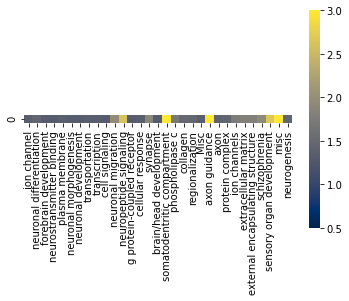

C1


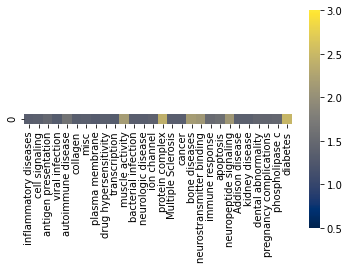

C2


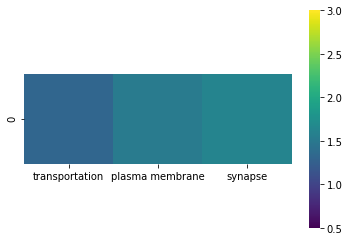

C2


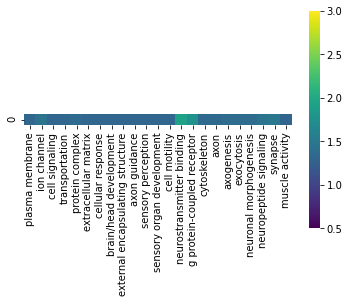

C3


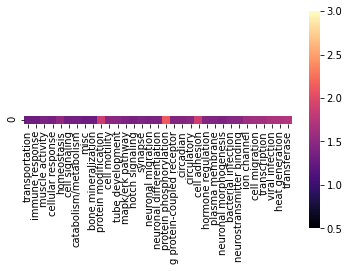

C3


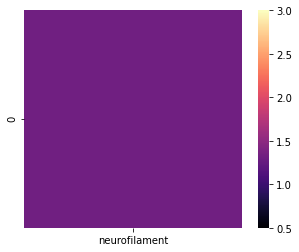

In [35]:
# Then we display and save the heatmap for FDR (sorted by counts)
colors = {'C1':'cividis','C2':'viridis','C3':'magma'}
sortby = 'counts' # counts
valueby = 'FDR Q' # counts
for nm,gmap in go_maps.items():
    comp,tail = nm.split('_')
    if tail == 'top':
        ind = gmap.sort_values(sortby,ascending=True).index
    else:
        ind = gmap.sort_values(sortby,ascending=False).index
    sns.heatmap(gmap.loc[ind,valueby].T.values.reshape(1,-1),square = True,
                xticklabels=gmap.loc[ind,valueby].T.index,
               vmin=0.5,vmax=3,cmap=colors[comp])
    print(comp)
    #plt.savefig(os.path.join(figdir,'GO_Matrix_%s_FDR_Dec2021.pdf'%nm),bbox_inches='tight')
    plt.show()

C1


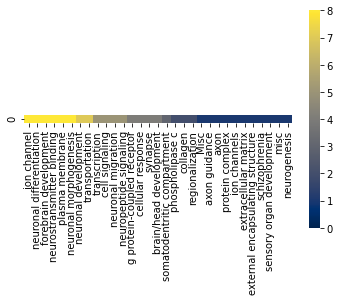

C1


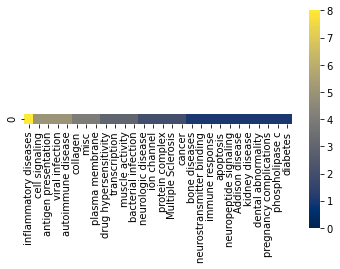

C2


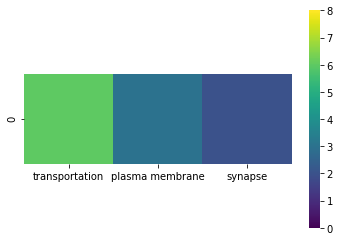

C2


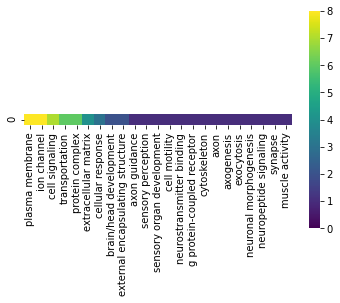

C3


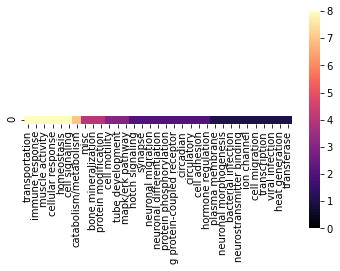

C3


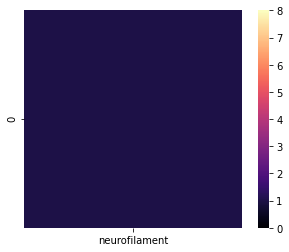

In [36]:
# and we display and save the heatmap for counts (sorted by counts)
colors = {'C1':'cividis','C2':'viridis','C3':'magma'}
sortby = 'counts' # counts
value_by = 'counts'
for nm,gmap in go_maps.items():
    comp,tail = nm.split('_')
    if tail == 'top':
        ind = gmap.sort_values(sortby,ascending=True).index
    else:
        ind = gmap.sort_values(sortby,ascending=False).index
    sns.heatmap(gmap.loc[ind,value_by].T.values.reshape(1,-1),square = True,
                xticklabels=gmap.loc[ind,value_by].T.index,
               vmin=0,vmax=8,
                cmap=colors[comp])
    print(comp)
    #plt.savefig(os.path.join(figdir,'GO_Matrix_%s_counts_Dec2021.pdf'%nm), bbox_inches='tight')
    plt.show()

<AxesSubplot:>

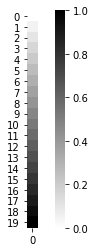

In [37]:
# And we save a general color scale in grayscale that indicates the meaning of each heatmap
# irrespective of the color
sns.heatmap(np.linspace(0,1,20).reshape(-1,1),square=True,cmap='binary')
#plt.savefig(os.path.join(figdir,'GO_Matrix_binary_cscale.pdf'),bbox_inches='tight')

In [38]:
# I used this code to re-add the text labels for heatmap when I edited them for the figure.
for x in go_maps['C3_Head'].sort_values('counts',ascending=False).index.tolist():
    #print(x+' -')
    print('-'+x)

-transportation
-immune response
-muscle activity
-cellular response
-homeostasis
-cell signaling
-catabolism/metabolism
-misc
-bone mineralization
-protein modification
-cell motility
-tube development
-mapk/erk pathway
-notch signaling
-synapse
-neuronal migration
-neuronal differentiation
-protein phosphorylation
-g protein-coupled receptor
-circadian
-circulatory
-cell adhesion
-hormone regulation
-plasma membrane
-neuronal morphogenesis
-bacterial infection
-neurostransmitter binding
-ion channel
-cell migration
-transcription
-viral infection
-heat generation
-transferase
